In [96]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import geopandas as gpd
import subprocess
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import contextily as ctx

# In this notebook we will: 
- Compare our observed width (measured during flowtracker transects) to our channel widths derived from satellite images at 100m and 10m sample frequency.
- Calibrate our Mannings N values for each node based on a latin hypercube. Whichever mannings N gets our modeled depth closest to our observed depth will be selected. nodes without observations will use the mannings N from the closest paired observation.

### Read in our flowtracker width observations

In [21]:
#reading in data with relative paths so that it can be used by others who clone repository from github

# need to use '..' to go up to parent directory to access observations
flowtracker_path = os.path.join(script_dir, '..', '..', 'observations', 'FlowTrackerObs', 'Mainstem_flowtracker.csv')
flowtracker_path = os.path.abspath(flowtracker_path)  # Resolve '..' and convert to an absolute path

#print(flowtracker_path)
# Reading the CSV file
master_flowtracker = pd.read_csv(flowtracker_path)
master_flowtracker



,index,STREAM_KM,Lat,Lon,Name.1,Datetime,Width,Area,Discharge,discharge_uncertaintyIVE_perc,Depth,Velocity,velocity_uncertaintyIVE_perc
0,WF_ebloomingdaleRd,15.1,43.638220,-90.773430,Wf.eblmrd,6/22/2023 10:01,7.60,2.024,0.476,4.785,0.266,0.235,3.757
1,WF_hayesDOWN,17.6,43.654730,-90.780990,Wf.hayesdn,6/22/2023 13:55,6.80,1.891,0.423,6.230,0.278,0.224,5.936
2,WF_hayesUP,18.5,43.661720,-90.785160,Wf.hayesup2,6/22/2023 16:06,7.60,2.334,0.348,5.416,0.307,0.149,4.593
3,WF_hwy82UP,2.7,43.563830,-90.761460,Wf.hwy82up,5/31/2023 16:12,12.79,4.094,1.078,4.646,0.320,0.263,3.215
4,WF_lukensDOWN,0.0,43.553130,-90.747600,Wf.lukensdown,5/31/2023 11:30,12.90,3.536,1.274,3.144,0.274,0.360,2.323
5,WF_lukensUP,1.2,43.556200,-90.754500,Wf.lukensup,5/31/2023 9:09,16.80,5.736,1.210,2.599,0.341,0.211,1.409
6,WF_pietschrd,7.2,43.589424,-90.773142,Wf.pietsch,6/23/2023 7:21,7.16,2.399,1.076,4.258,0.335,0.449,3.922
7,WF_riverview,19.1,43.665980,-90.789750,Wf.rrunup,7/18/2023 11:47,3.95,0.831,0.147,7.366,0.210,0.177,6.928
8,WF_saunders,4.3,43.573530,-90.763660,Wf.saunders,7/20/2023 9:33,15.40,7.012,0.944,2.474,0.455,0.135,1.771
9,WF_smarthallow,10.9,43.613080,-90.781280,Wf.smarthallowup,6/1/2023 7:18,10.65,3.806,0.596,5.296,0.357,0.156,3.151


#### Filter observation dataframe so it just gives us width and depth

In [60]:
# make a new df thats just width and downstream distance, so we can compare to GIS measurements
width_obs = master_flowtracker[['STREAM_KM', 'Width', 'Depth']].copy()
width_obs

width_obs = width_obs.set_index('STREAM_KM')
width_obs.drop(19.1, axis=0, inplace=True)

width_obs['distance downstream'] = 18.5 - width_obs.index

width_obs.index.name = 'NODE_ID'
width_obs = width_obs.sort_values(by='distance downstream')

width_obs
# flat_df['distance downstream'] = 18.3 - flat_df['NODE_ID']
# flat_width = flat_width.set_index('NODE_ID')

# width_obs = flat_width.sort_values(by='distance downstream')

# width_obs

,Width,Depth,distance downstream
NODE_ID,,,
18.5,7.60,0.307,0.0
17.6,6.80,0.278,0.9
16.2,7.60,0.265,2.3
15.1,7.60,0.266,3.4
13.9,7.50,0.266,4.6
12.3,12.45,0.202,6.2
11.8,13.80,0.322,6.7
10.9,10.65,0.357,7.6
9.1,6.05,0.264,9.4


### Read in the simulated widths in a df with the same column names as observed

In [63]:
#100 meter sampled widths
sim_width100m_path = os.path.join(script_dir, '..', '..', 'calibration', 'ManningsN', 'inputs', 'WFK23_morphology.csv')
sim_width100m = pd.read_csv(sim_width100m_path, usecols=['STREAM_KM', 'BOTTOM_WIDTH'])
sim_width100m.rename(columns={'STREAM_KM': 'NODE_ID', 'BOTTOM_WIDTH' : 'Width'}, inplace=True)
sim_width100m['distance downstream'] = 18.5 - sim_width100m['NODE_ID']
sim_width100m = sim_width100m.set_index('NODE_ID')
sim_width100m

,Width,distance downstream
NODE_ID,,
18.5,4.622692,0.0
18.4,8.533761,0.1
18.3,5.389599,0.2
18.2,8.310317,0.3
18.1,14.653057,0.4
...,...,...
0.4,8.194620,18.1
0.3,8.272932,18.2
0.2,11.853601,18.3


In [69]:
#10 meter sampled widths
sim_width10m_path = os.path.join(script_dir, '..', '..', 'calibration', 'ManningsN', 'TTools_10mwidths.csv')
sim_width10m = pd.read_csv(sim_width10m_path, usecols=['STREAM_KM', 'CHANWIDTH'])
sim_width10m.rename(columns={'STREAM_KM': 'NODE_ID', 'CHANWIDTH' : 'Width'}, inplace=True)
sim_width10m['distance downstream'] = 18.5 - sim_width10m['NODE_ID']
sim_width10m = sim_width10m.set_index('NODE_ID')
sim_width10m

,Width,distance downstream
NODE_ID,,
18.51,8.222575,-0.01
18.50,4.622692,0.00
18.49,5.864788,0.01
18.48,8.156040,0.02
18.47,9.855347,0.03
...,...,...
0.04,13.706363,18.46
0.03,14.006901,18.47
0.02,11.874497,18.48


### Plot the observed widths (blue dots) vs the widths measured with GIS (red line)

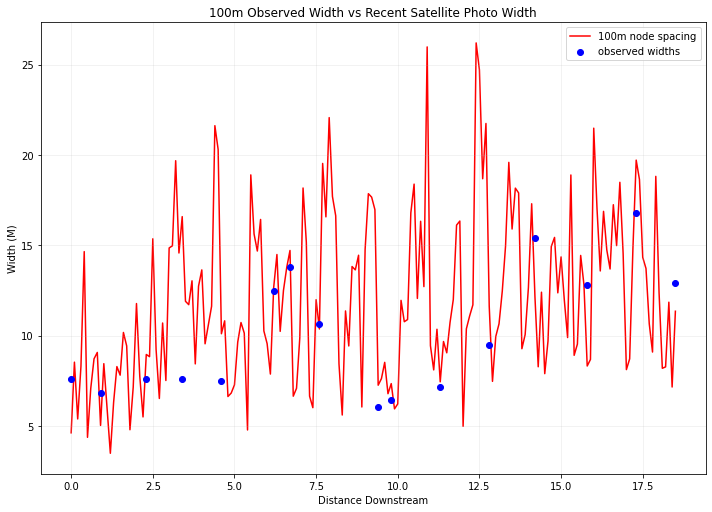

In [81]:
plt.figure(figsize=(10, 7))

plt.plot(sim_width100m['distance downstream'], sim_width100m['Width'], label = '100m node spacing',color = 'red',zorder=0)

plt.scatter(width_obs['distance downstream'], width_obs['Width'], label = 'observed widths',color = 'blue',zorder = 2)
plt.legend()
plt.ylabel('Width (M)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(19, 22)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('100m Observed Width vs Recent Satellite Photo Width')
plt.savefig('DepthDownstreamvsOBS_01.png')
plt.show()


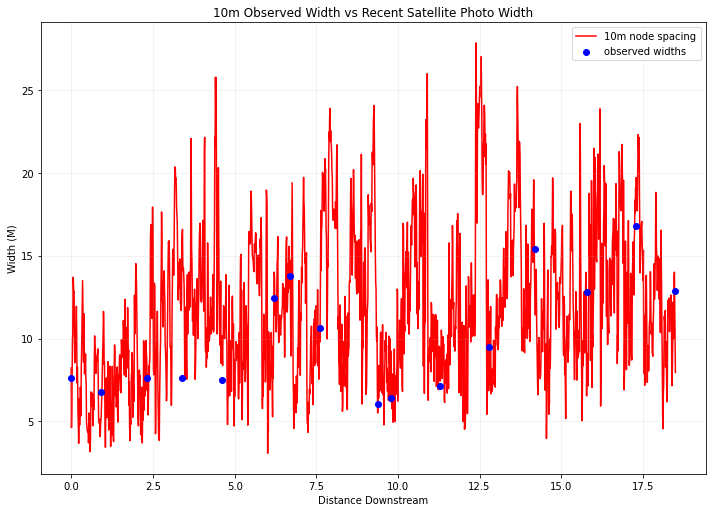

In [79]:
plt.figure(figsize=(10, 7))

plt.plot(sim_width10m['distance downstream'], sim_width10m['Width'], label = '10m node spacing',color = 'red',zorder=0)

plt.scatter(width_obs['distance downstream'], width_obs['Width'], label = 'observed widths',color = 'blue', zorder=2)

plt.legend()
plt.ylabel('Width (M)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(19, 22)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('10m Observed Width vs Recent Satellite Photo Width')
plt.savefig('DepthDownstreamvsOBS_01.png')
plt.show()


### Rolling average of 10m Widths

In [83]:
sim_width100m['rolling_avg'] = sim_width10m['Width'].rolling(window=11, center=True, min_periods=1).mean()
sim_width100m

,Width,distance downstream,rolling_avg
NODE_ID,,,
18.5,4.622692,0.0,8.689268
18.4,8.533761,0.1,11.184814
18.3,5.389599,0.2,6.804663
18.2,8.310317,0.3,8.669108
18.1,14.653057,0.4,9.100400
...,...,...,...
0.4,8.194620,18.1,9.910813
0.3,8.272932,18.2,9.222260
0.2,11.853601,18.3,10.914819


### Plotting the rolling average of widths

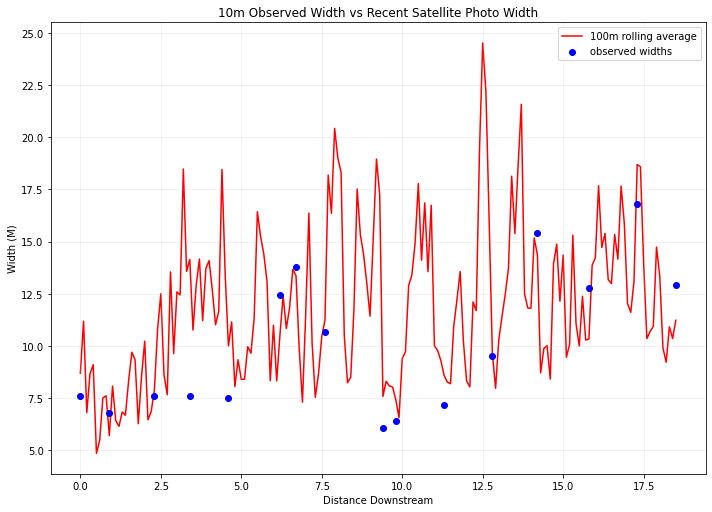

In [85]:
plt.figure(figsize=(10, 7))

plt.plot(sim_width100m['distance downstream'], sim_width100m['rolling_avg'], label = '100m rolling average',color = 'red',zorder=0)

plt.scatter(width_obs['distance downstream'], width_obs['Width'], label = 'observed widths',color = 'blue', zorder=2)

plt.legend()
plt.ylabel('Width (M)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(19, 22)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('10m Observed Width vs Recent Satellite Photo Width')
plt.savefig('DepthDownstreamvsOBS_01.png')
plt.show()


### Comparing to 2020 ortho measurements
D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\calibration\03152024_updatedinputs\June\inputsb

In [93]:
#100 meter sampled widths
sim_width2020 = pd.read_csv(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\top10_restorationscenario\inputs\WFK23_morphology.csv', usecols=['STREAM_KM', 'BOTTOM_WIDTH'])
sim_width2020.rename(columns={'STREAM_KM': 'NODE_ID', 'BOTTOM_WIDTH' : 'Width'}, inplace=True)
sim_width2020['distance downstream'] = 27.2 - sim_width2020['NODE_ID']
sim_width2020 = sim_width2020.set_index('NODE_ID')
sim_width2020

,Width,distance downstream
NODE_ID,,
27.2,7.600000,0.0
27.1,8.625470,0.1
27.0,8.437560,0.2
26.9,13.019598,0.3
26.8,10.344102,0.4
...,...,...
0.4,11.817464,26.8
0.3,11.817464,26.9
0.2,11.817464,27.0


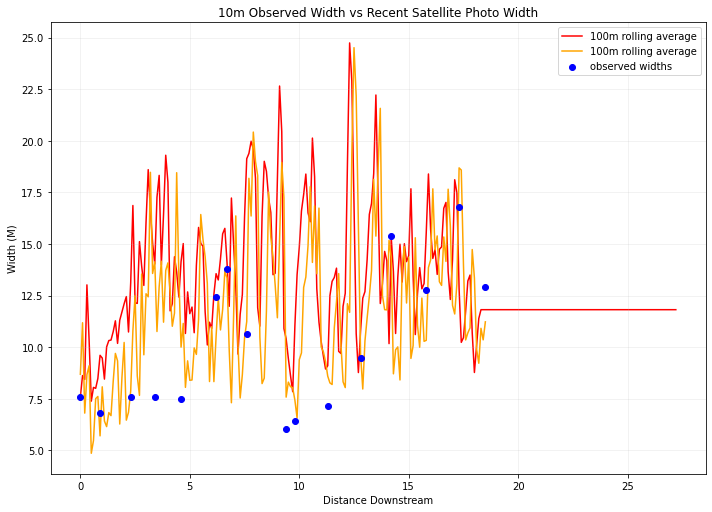

In [94]:
plt.figure(figsize=(10, 7))

plt.plot(sim_width2020['distance downstream'], sim_width2020['Width'], label = '100m rolling average',color = 'red',zorder=0)
plt.plot(sim_width100m['distance downstream'], sim_width100m['rolling_avg'], label = '100m rolling average',color = 'orange',zorder=0)

plt.scatter(width_obs['distance downstream'], width_obs['Width'], label = 'observed widths',color = 'blue', zorder=2)

plt.legend()
plt.ylabel('Width (M)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(19, 22)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('10m Observed Width vs Recent Satellite Photo Width')
plt.savefig('DepthDownstreamvsOBS_01.png')
plt.show()


### Latin Hypercube for calibrating mannings N

In [95]:
sampler = qmc.LatinHypercube(d=1)
sample = sampler.random(n=20)

l_bounds = [.01]
u_bounds = [.15]
lhs = qmc.scale(sample, l_bounds, u_bounds)
lhs

array([[0.08078552],
       [0.10006509],
       [0.04601128],
       [0.0259702 ],
       [0.02280027],
       [0.01024551],
       [0.12666612],
       [0.11400934],
       [0.11547007],
       [0.06772086],
       [0.07492008],
       [0.06193579],
       [0.1375024 ],
       [0.0531191 ],
       [0.14892943],
       [0.10100848],
       [0.1356856 ],
       [0.08718099],
       [0.03965786],
       [0.03116529]])

In [100]:
for n in range(25):
    #getting the mannings n from hypercube for loop
    mannings = round(float(lhs[n]),4)
    #make new folders for mannings run
    original_folder_path = os.path.join(script_dir, '..', '..', 'calibration', 'ManningsN')
    original_folder_path = os.path.abspath(original_folder_path)
    new_folder_name = f"manningsN_{mannings}"  # You can adjust the folder name as needed
    new_folder_path = os.path.join(original_folder_path, 'hypercube_rollingaveragewidth', f'runsWFK_100m{new_folder_name}')
    #copy files from base run
    shutil.copytree(original_folder_path, new_folder_path)
    #change control file so that model run uses correct files
    control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
    control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
    control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
    control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)
    #update mannings n file with new mannings N
    morph_file = pd.read_csv(os.path.join(new_folder_path, 'inputs', 'WFK23_morphology.csv'))
    morph_file['MANNINGS_n'] = mannings  # Assuming lhs is properly defined elsewhere
    print(morph_file['MANNINGS_n'])  # Assuming lhs is properly defined elsewhere
    morph_file.to_csv(os.path.join(new_folder_path, "inputs", 'WFK23_morphology.csv'), index=False)
    try:
        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        loop_counter+=1
        print(str(loop_counter) + ' successful runs')
    except:
        print('run #: ' + str(mannings) + ' failed.')
        continue
    
  



Error: [('d:\\Ben_wd\\THESIS\\heatsource\\post_defense\\calibration\\ManningsN\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\HeatSource_Control.csv', 'd:\\Ben_wd\\THESIS\\heatsource\\post_defense\\calibration\\ManningsN\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\HeatSource_Control.csv', "[Errno 2] No such file or directory: 'd:\\\\Ben_wd\\\\THESIS\\\\heatsource\\\\post_defense\\\\calibration\\\\ManningsN\\\\hypercube_rollingaveragewidth\\\\runsWFK_100mmanningsN_0.0808\\\\hypercube_rollingaveragewidth\\\\runsWFK_100mmanningsN_0.0808\\\\hypercube_rollingaveragewidth\\\\runsWFK_100mmanningsN_0.0808\\\\HeatSource_Control.csv'"), ('d:\\Ben_wd\\THESIS\\heatsource\\post_defense\\calibration\\ManningsN\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth', 'd:\\Ben_wd\\THESIS\\heatsource\\post_defense\\calibration\\ManningsN\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth\\runsWFK_100mmanningsN_0.0808\\hypercube_rollingaveragewidth', "[WinError 3] The system cannot find the path specified: 'd:\\\\Ben_wd\\\\THESIS\\\\heatsource\\\\post_defense\\\\calibration\\\\ManningsN\\\\hypercube_rollingaveragewidth\\\\runsWFK_100mmanningsN_0.0808\\\\hypercube_rollingaveragewidth\\\\runsWFK_100mmanningsN_0.0808\\\\hypercube_rollingaveragewidth\\\\runsWFK_100mmanningsN_0.0808\\\\hypercube_rollingaveragewidth'")]